In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchinfo import summary
from comet_ml import Experiment

# Local imports
sys.path.append("/Users/leo/Programming/Thesis/utils")
sys.path.append("/Users/leo/Programming/Thesis/models")

from helper_functions import (delete_ds_store,plot_metrics,test,train,mean_std_finder,load_model)
from GhostNet import ghost_net
from config import comet_token, project_name, workspace
from torchvision.models import (mobilenet_v3_small, MobileNet_V3_Small_Weights as weights_small)

# Setting the seed for reproducibility
torch.manual_seed(42)

In [2]:
prms = {
    "backbone": mobilenet_v3_small,
    "weights": None,
    "module": "ghost",
    "module_alias": "GhostNet",
    "data_path": "/Users/leo/Programming/Thesis/data/ImageNet_100/",
    "batch_size": 32,
    "img_size": 224,
    "num_classes": 100,
    "epochs": 25,
    "learning_rate": 0.001,
    "device": "mps",
    "model": None,
    "experiment": Experiment(api_key=comet_token, project_name=project_name, workspace=workspace, log_code=True),
    "load_model": False,
}
prms["model_save_path"] = f"./saved_weights/{prms['module_alias']}_{prms['data_path'].split('/')[-2]}.pth"

model = prms["model"] = ghost_net(num_classes=prms["num_classes"], module_type = prms["module"])
delete_ds_store(prms["data_path"])

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/leothesouthafrican/test/93e6f67570434e719f65bbb5af4f1f34



In [3]:
#mean, std = mean_std_finder(prms["data_path"])
mean, std = torch.tensor([0.5235, 0.4358, 0.3905]), torch.tensor([0.2993, 0.2770, 0.2729])

train_transform = transforms.Compose([
    transforms.Resize((prms["img_size"], prms["img_size"])),
    transforms.RandAugment(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.Resize((prms["img_size"], prms["img_size"])),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [4]:
#Accessing the data
train_data = torchvision.datasets.ImageFolder(prms["data_path"] + "train/", transform=train_transform)
val_data = torchvision.datasets.ImageFolder(prms["data_path"] + "val/", transform=test_transform)
test_data = torchvision.datasets.ImageFolder(prms["data_path"] + "test/", transform=test_transform)

#Creating the data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=prms["batch_size"], shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=prms["batch_size"], shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=prms["batch_size"], shuffle=False, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


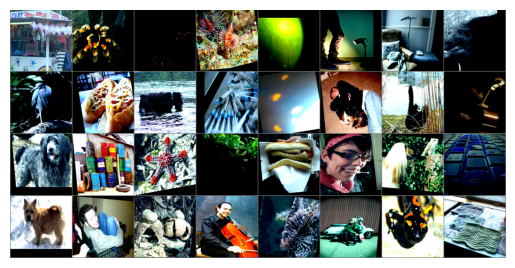

In [5]:
#display random images from the dataset
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #drop axis labels
    plt.axis('off')
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

In [6]:
#build the model
model = prms["model"].to(prms["device"])

# Loss and optimizer
criterion = nn.CrossEntropyLoss().to(prms["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=prms["learning_rate"])
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

prms["experiment"].log_parameters({"loss": criterion, "optimizer": optimizer}) if prms["experiment"] else None

In [7]:
model_summary = summary(model, input_size=(1, 3, prms["img_size"], prms["img_size"]),
        col_names = ["input_size", "output_size", "num_params", "kernel_size", "mult_adds", "trainable"],
        col_width = 20,
        row_settings = ["var_names"],
        depth=8)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
prms["experiment"].log_metric("total_params", total_params) if prms["experiment"] else None

model_summary

/Users/leo/Programming/Thesis/thesis_env/lib/python3.9/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),


Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Kernel Shape         Mult-Adds            Trainable
GhostNet (GhostNet)                                     [1, 3, 224, 224]     [1, 100]             --                   --                   --                   True
├─Sequential (features)                                 [1, 3, 224, 224]     [1, 96, 7, 7]        --                   --                   --                   True
│    └─Sequential (0)                                   [1, 3, 224, 224]     [1, 16, 112, 112]    --                   --                   --                   True
│    │    └─Conv2d (0)                                  [1, 3, 224, 224]     [1, 16, 112, 112]    432                  [3, 3]               5,419,008            True
│    │    └─BatchNorm2d (1)                             [1, 16, 112, 112]    [1, 16, 112, 112]    32                   --                   32                   True

100%|██████████| 377/377 [01:09<00:00,  5.45it/s]
Exception ignored in: <function BaseCAM.__del__ at 0x175ffcaf0>
Traceback (most recent call last):
  File "/Users/leo/Programming/Thesis/thesis_env/lib/python3.9/site-packages/pytorch_grad_cam/base_cam.py", line 192, in __del__
    self.activations_and_grads.release()
AttributeError: 'GradCAM' object has no attribute 'activations_and_grads'


Error logging images to comet_ml
Epoch: 01 | Epoch Time: 18.0m 8s
	Train Loss: 3.972 | Train Acc: 10.64%
	 Val. Loss: 3.260 |  Val. Acc: 21.80%
Best Accuracy Achieved: 21.80% on epoch 01


100%|██████████| 377/377 [01:08<00:00,  5.49it/s]
Exception ignored in: <function BaseCAM.__del__ at 0x175ffcaf0>
Traceback (most recent call last):
  File "/Users/leo/Programming/Thesis/thesis_env/lib/python3.9/site-packages/pytorch_grad_cam/base_cam.py", line 192, in __del__
    self.activations_and_grads.release()
AttributeError: 'GradCAM' object has no attribute 'activations_and_grads'


Error logging images to comet_ml
Epoch: 02 | Epoch Time: 17.0m 37s
	Train Loss: 3.175 | Train Acc: 22.94%
	 Val. Loss: 2.644 |  Val. Acc: 32.92%
Best Accuracy Achieved: 32.92% on epoch 02


100%|██████████| 377/377 [01:10<00:00,  5.36it/s]
Exception ignored in: <function BaseCAM.__del__ at 0x175ffcaf0>
Traceback (most recent call last):
  File "/Users/leo/Programming/Thesis/thesis_env/lib/python3.9/site-packages/pytorch_grad_cam/base_cam.py", line 192, in __del__
    self.activations_and_grads.release()
AttributeError: 'GradCAM' object has no attribute 'activations_and_grads'


Error logging images to comet_ml
Epoch: 03 | Epoch Time: 17.0m 45s
	Train Loss: 2.663 | Train Acc: 33.32%
	 Val. Loss: 2.241 |  Val. Acc: 42.21%
Best Accuracy Achieved: 42.21% on epoch 03


100%|██████████| 377/377 [01:08<00:00,  5.53it/s]
Exception ignored in: <function BaseCAM.__del__ at 0x175ffcaf0>
Traceback (most recent call last):
  File "/Users/leo/Programming/Thesis/thesis_env/lib/python3.9/site-packages/pytorch_grad_cam/base_cam.py", line 192, in __del__
    self.activations_and_grads.release()
AttributeError: 'GradCAM' object has no attribute 'activations_and_grads'


Error logging images to comet_ml
Epoch: 04 | Epoch Time: 17.0m 50s
	Train Loss: 2.332 | Train Acc: 40.80%
	 Val. Loss: 2.037 |  Val. Acc: 47.11%
Best Accuracy Achieved: 47.11% on epoch 04


100%|██████████| 377/377 [01:09<00:00,  5.42it/s]
Exception ignored in: <function BaseCAM.__del__ at 0x175ffcaf0>
Traceback (most recent call last):
  File "/Users/leo/Programming/Thesis/thesis_env/lib/python3.9/site-packages/pytorch_grad_cam/base_cam.py", line 192, in __del__
    self.activations_and_grads.release()
AttributeError: 'GradCAM' object has no attribute 'activations_and_grads'


Error logging images to comet_ml
Epoch: 05 | Epoch Time: 17.0m 48s
	Train Loss: 2.096 | Train Acc: 46.04%
	 Val. Loss: 1.895 |  Val. Acc: 51.04%
Best Accuracy Achieved: 51.04% on epoch 05


100%|██████████| 377/377 [01:08<00:00,  5.52it/s]
Exception ignored in: <function BaseCAM.__del__ at 0x175ffcaf0>
Traceback (most recent call last):
  File "/Users/leo/Programming/Thesis/thesis_env/lib/python3.9/site-packages/pytorch_grad_cam/base_cam.py", line 192, in __del__
    self.activations_and_grads.release()
AttributeError: 'GradCAM' object has no attribute 'activations_and_grads'


Error logging images to comet_ml
Epoch: 06 | Epoch Time: 17.0m 41s
	Train Loss: 1.925 | Train Acc: 49.86%
	 Val. Loss: 1.711 |  Val. Acc: 55.23%
Best Accuracy Achieved: 55.23% on epoch 06


100%|██████████| 377/377 [01:09<00:00,  5.45it/s]
Exception ignored in: <function BaseCAM.__del__ at 0x175ffcaf0>
Traceback (most recent call last):
  File "/Users/leo/Programming/Thesis/thesis_env/lib/python3.9/site-packages/pytorch_grad_cam/base_cam.py", line 192, in __del__
    self.activations_and_grads.release()
AttributeError: 'GradCAM' object has no attribute 'activations_and_grads'


Error logging images to comet_ml
Epoch: 07 | Epoch Time: 17.0m 41s
	Train Loss: 1.783 | Train Acc: 53.14%
	 Val. Loss: 1.682 |  Val. Acc: 56.28%
Best Accuracy Achieved: 56.28% on epoch 07


100%|██████████| 377/377 [01:09<00:00,  5.41it/s]
Exception ignored in: <function BaseCAM.__del__ at 0x175ffcaf0>
Traceback (most recent call last):
  File "/Users/leo/Programming/Thesis/thesis_env/lib/python3.9/site-packages/pytorch_grad_cam/base_cam.py", line 192, in __del__
    self.activations_and_grads.release()
AttributeError: 'GradCAM' object has no attribute 'activations_and_grads'


Error logging images to comet_ml
Epoch: 08 | Epoch Time: 17.0m 42s
	Train Loss: 1.671 | Train Acc: 55.67%
	 Val. Loss: 1.588 |  Val. Acc: 58.64%
Best Accuracy Achieved: 58.64% on epoch 08


100%|██████████| 377/377 [01:14<00:00,  5.03it/s]
Exception ignored in: <function BaseCAM.__del__ at 0x175ffcaf0>
Traceback (most recent call last):
  File "/Users/leo/Programming/Thesis/thesis_env/lib/python3.9/site-packages/pytorch_grad_cam/base_cam.py", line 192, in __del__
    self.activations_and_grads.release()
AttributeError: 'GradCAM' object has no attribute 'activations_and_grads'


Error logging images to comet_ml
Epoch: 09 | Epoch Time: 354.0m 39s
	Train Loss: 1.570 | Train Acc: 58.00%
	 Val. Loss: 1.524 |  Val. Acc: 60.42%
Best Accuracy Achieved: 60.42% on epoch 09


100%|██████████| 377/377 [01:03<00:00,  5.96it/s]
Exception ignored in: <function BaseCAM.__del__ at 0x175ffcaf0>
Traceback (most recent call last):
  File "/Users/leo/Programming/Thesis/thesis_env/lib/python3.9/site-packages/pytorch_grad_cam/base_cam.py", line 192, in __del__
    self.activations_and_grads.release()
AttributeError: 'GradCAM' object has no attribute 'activations_and_grads'


Error logging images to comet_ml
Epoch: 10 | Epoch Time: 17.0m 50s
	Train Loss: 1.484 | Train Acc: 60.14%
	 Val. Loss: 1.509 |  Val. Acc: 60.67%
Best Accuracy Achieved: 60.67% on epoch 10


100%|██████████| 377/377 [01:04<00:00,  5.83it/s]
Exception ignored in: <function BaseCAM.__del__ at 0x175ffcaf0>
Traceback (most recent call last):
  File "/Users/leo/Programming/Thesis/thesis_env/lib/python3.9/site-packages/pytorch_grad_cam/base_cam.py", line 192, in __del__
    self.activations_and_grads.release()
AttributeError: 'GradCAM' object has no attribute 'activations_and_grads'


Error logging images to comet_ml
Epoch: 11 | Epoch Time: 16.0m 41s
	Train Loss: 1.416 | Train Acc: 61.81%
	 Val. Loss: 1.459 |  Val. Acc: 61.97%
Best Accuracy Achieved: 61.97% on epoch 11


100%|██████████| 377/377 [01:02<00:00,  6.01it/s]
Exception ignored in: <function BaseCAM.__del__ at 0x175ffcaf0>
Traceback (most recent call last):
  File "/Users/leo/Programming/Thesis/thesis_env/lib/python3.9/site-packages/pytorch_grad_cam/base_cam.py", line 192, in __del__
    self.activations_and_grads.release()
AttributeError: 'GradCAM' object has no attribute 'activations_and_grads'


Error logging images to comet_ml
Epoch: 12 | Epoch Time: 16.0m 10s
	Train Loss: 1.346 | Train Acc: 63.55%
	 Val. Loss: 1.453 |  Val. Acc: 62.35%
Best Accuracy Achieved: 62.35% on epoch 12


100%|██████████| 377/377 [01:01<00:00,  6.13it/s]
Exception ignored in: <function BaseCAM.__del__ at 0x175ffcaf0>
Traceback (most recent call last):
  File "/Users/leo/Programming/Thesis/thesis_env/lib/python3.9/site-packages/pytorch_grad_cam/base_cam.py", line 192, in __del__
    self.activations_and_grads.release()
AttributeError: 'GradCAM' object has no attribute 'activations_and_grads'


Error logging images to comet_ml
Epoch: 13 | Epoch Time: 15.0m 56s
	Train Loss: 1.286 | Train Acc: 64.89%
	 Val. Loss: 1.505 |  Val. Acc: 61.97%


100%|██████████| 377/377 [01:02<00:00,  6.07it/s]
Exception ignored in: <function BaseCAM.__del__ at 0x175ffcaf0>
Traceback (most recent call last):
  File "/Users/leo/Programming/Thesis/thesis_env/lib/python3.9/site-packages/pytorch_grad_cam/base_cam.py", line 192, in __del__
    self.activations_and_grads.release()
AttributeError: 'GradCAM' object has no attribute 'activations_and_grads'


Error logging images to comet_ml
Epoch: 14 | Epoch Time: 15.0m 45s
	Train Loss: 1.229 | Train Acc: 66.20%
	 Val. Loss: 1.458 |  Val. Acc: 63.25%
Best Accuracy Achieved: 63.25% on epoch 14


100%|██████████| 377/377 [01:01<00:00,  6.10it/s]
Exception ignored in: <function BaseCAM.__del__ at 0x175ffcaf0>
Traceback (most recent call last):
  File "/Users/leo/Programming/Thesis/thesis_env/lib/python3.9/site-packages/pytorch_grad_cam/base_cam.py", line 192, in __del__
    self.activations_and_grads.release()
AttributeError: 'GradCAM' object has no attribute 'activations_and_grads'


Error logging images to comet_ml
Epoch: 15 | Epoch Time: 15.0m 45s
	Train Loss: 1.175 | Train Acc: 67.72%
	 Val. Loss: 1.435 |  Val. Acc: 62.84%


100%|██████████| 377/377 [01:01<00:00,  6.10it/s]
Exception ignored in: <function BaseCAM.__del__ at 0x175ffcaf0>
Traceback (most recent call last):
  File "/Users/leo/Programming/Thesis/thesis_env/lib/python3.9/site-packages/pytorch_grad_cam/base_cam.py", line 192, in __del__
    self.activations_and_grads.release()
AttributeError: 'GradCAM' object has no attribute 'activations_and_grads'


Error logging images to comet_ml
Epoch: 16 | Epoch Time: 15.0m 40s
	Train Loss: 1.126 | Train Acc: 68.84%
	 Val. Loss: 1.497 |  Val. Acc: 62.48%


100%|██████████| 377/377 [01:00<00:00,  6.21it/s]
Exception ignored in: <function BaseCAM.__del__ at 0x175ffcaf0>
Traceback (most recent call last):
  File "/Users/leo/Programming/Thesis/thesis_env/lib/python3.9/site-packages/pytorch_grad_cam/base_cam.py", line 192, in __del__
    self.activations_and_grads.release()
AttributeError: 'GradCAM' object has no attribute 'activations_and_grads'


Error logging images to comet_ml
Epoch: 17 | Epoch Time: 15.0m 43s
	Train Loss: 1.081 | Train Acc: 69.79%
	 Val. Loss: 1.449 |  Val. Acc: 63.67%
Best Accuracy Achieved: 63.67% on epoch 17


100%|██████████| 377/377 [01:01<00:00,  6.13it/s]
Exception ignored in: <function BaseCAM.__del__ at 0x175ffcaf0>
Traceback (most recent call last):
  File "/Users/leo/Programming/Thesis/thesis_env/lib/python3.9/site-packages/pytorch_grad_cam/base_cam.py", line 192, in __del__
    self.activations_and_grads.release()
AttributeError: 'GradCAM' object has no attribute 'activations_and_grads'


Error logging images to comet_ml
Epoch: 18 | Epoch Time: 15.0m 44s
	Train Loss: 1.040 | Train Acc: 70.83%
	 Val. Loss: 1.473 |  Val. Acc: 63.18%


100%|██████████| 377/377 [01:11<00:00,  5.28it/s]
Exception ignored in: <function BaseCAM.__del__ at 0x175ffcaf0>
Traceback (most recent call last):
  File "/Users/leo/Programming/Thesis/thesis_env/lib/python3.9/site-packages/pytorch_grad_cam/base_cam.py", line 192, in __del__
    self.activations_and_grads.release()
AttributeError: 'GradCAM' object has no attribute 'activations_and_grads'


Error logging images to comet_ml
Epoch: 19 | Epoch Time: 16.0m 27s
	Train Loss: 0.996 | Train Acc: 71.86%
	 Val. Loss: 1.433 |  Val. Acc: 64.41%
Best Accuracy Achieved: 64.41% on epoch 19


100%|██████████| 377/377 [01:02<00:00,  6.07it/s]
Exception ignored in: <function BaseCAM.__del__ at 0x175ffcaf0>
Traceback (most recent call last):
  File "/Users/leo/Programming/Thesis/thesis_env/lib/python3.9/site-packages/pytorch_grad_cam/base_cam.py", line 192, in __del__
    self.activations_and_grads.release()
AttributeError: 'GradCAM' object has no attribute 'activations_and_grads'


Error logging images to comet_ml
Epoch: 20 | Epoch Time: 16.0m 37s
	Train Loss: 0.959 | Train Acc: 72.76%
	 Val. Loss: 1.432 |  Val. Acc: 64.71%
Best Accuracy Achieved: 64.71% on epoch 20


100%|██████████| 377/377 [01:01<00:00,  6.14it/s]
Exception ignored in: <function BaseCAM.__del__ at 0x175ffcaf0>
Traceback (most recent call last):
  File "/Users/leo/Programming/Thesis/thesis_env/lib/python3.9/site-packages/pytorch_grad_cam/base_cam.py", line 192, in __del__
    self.activations_and_grads.release()
AttributeError: 'GradCAM' object has no attribute 'activations_and_grads'


Error logging images to comet_ml
Epoch: 21 | Epoch Time: 15.0m 40s
	Train Loss: 0.927 | Train Acc: 73.56%
	 Val. Loss: 1.457 |  Val. Acc: 64.87%
Best Accuracy Achieved: 64.87% on epoch 21


100%|██████████| 377/377 [01:28<00:00,  4.26it/s]
Exception ignored in: <function BaseCAM.__del__ at 0x175ffcaf0>
Traceback (most recent call last):
  File "/Users/leo/Programming/Thesis/thesis_env/lib/python3.9/site-packages/pytorch_grad_cam/base_cam.py", line 192, in __del__
    self.activations_and_grads.release()
AttributeError: 'GradCAM' object has no attribute 'activations_and_grads'


Error logging images to comet_ml
Epoch: 22 | Epoch Time: 36.0m 28s
	Train Loss: 0.893 | Train Acc: 74.43%
	 Val. Loss: 1.482 |  Val. Acc: 64.01%


100%|██████████| 377/377 [01:51<00:00,  3.38it/s]
Exception ignored in: <function BaseCAM.__del__ at 0x175ffcaf0>
Traceback (most recent call last):
  File "/Users/leo/Programming/Thesis/thesis_env/lib/python3.9/site-packages/pytorch_grad_cam/base_cam.py", line 192, in __del__
    self.activations_and_grads.release()
AttributeError: 'GradCAM' object has no attribute 'activations_and_grads'


Error logging images to comet_ml
Epoch: 23 | Epoch Time: 33.0m 41s
	Train Loss: 0.858 | Train Acc: 75.47%
	 Val. Loss: 1.492 |  Val. Acc: 65.17%
Best Accuracy Achieved: 65.17% on epoch 23


100%|██████████| 377/377 [01:52<00:00,  3.35it/s]
Exception ignored in: <function BaseCAM.__del__ at 0x175ffcaf0>
Traceback (most recent call last):
  File "/Users/leo/Programming/Thesis/thesis_env/lib/python3.9/site-packages/pytorch_grad_cam/base_cam.py", line 192, in __del__
    self.activations_and_grads.release()
AttributeError: 'GradCAM' object has no attribute 'activations_and_grads'


Error logging images to comet_ml
Epoch: 24 | Epoch Time: 38.0m 41s
	Train Loss: 0.830 | Train Acc: 76.07%
	 Val. Loss: 1.550 |  Val. Acc: 64.33%


100%|██████████| 377/377 [01:49<00:00,  3.45it/s]
Exception ignored in: <function BaseCAM.__del__ at 0x175ffcaf0>
Traceback (most recent call last):
  File "/Users/leo/Programming/Thesis/thesis_env/lib/python3.9/site-packages/pytorch_grad_cam/base_cam.py", line 192, in __del__
    self.activations_and_grads.release()
AttributeError: 'GradCAM' object has no attribute 'activations_and_grads'


Error logging images to comet_ml
Epoch: 25 | Epoch Time: 38.0m 45s
	Train Loss: 0.799 | Train Acc: 77.02%
	 Val. Loss: 1.577 |  Val. Acc: 64.30%


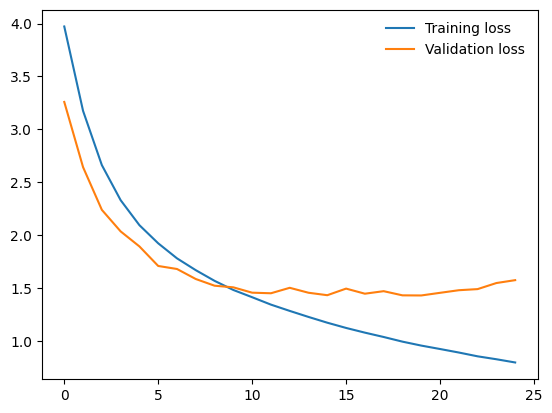

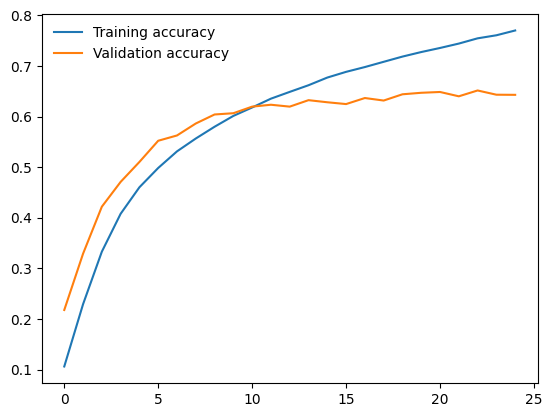

In [8]:
#train the model
train_losses, train_acc, val_losses, val_acc = train(model, train_loader, val_loader, criterion, optimizer, scheduler, hyper_params = prms, verbose = 2, test_transform = train_transform, experiment=prms["experiment"])

#plot the training and validation metrics
plot_metrics(train_losses, train_acc, val_losses, val_acc)

In [9]:
#test the model
test(model, test_loader, criterion, hyper_params = prms, experiment = prms["experiment"])

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/leothesouthafrican/test/93e6f67570434e719f65bbb5af4f1f34
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     inference_time  : 0.008997496056919052
COMET INFO:     test_accuracy   : 0.6366580724716187
COMET INFO:     test_loss       : 1.5361564260574188
COMET INFO:     total_params    : 1541938
COMET INFO:     train_acc [25]  : (0.10639029741287231, 0.7701807022094727)
COMET INFO:     train_loss [25] : (0.7994136887922072, 3.9723284516801343)
COMET INFO:     val_acc [25]    : (0.21799336373806, 0.6516583561897278)
COMET INFO:     val_loss [25]   : (1.432230464573548, 3.259589742230341)
COMET INFO:   Parameters:
COMET INFO:

Test loss: 1.536.. 
Test accuracy: 0.637
Test Time: 1.0m 48s 338ms


COMET INFO: Using '/Users/leo/Programming/Thesis/notebooks/.cometml-runs' path as offline directory. Pass 'offline_directory' parameter into constructor or set the 'COMET_OFFLINE_DIRECTORY' environment variable to manually choose where to store offline experiment archives.
COMET WARNING: Could not send live data to Comet during experiment runtime. An offline experiment will be available for upload:
    comet upload --force-reupload /Users/leo/Programming/Thesis/notebooks/.cometml-runs/93e6f67570434e719f65bbb5af4f1f34-nZbKUU.zip


(1.5361564260574188, tensor(0.6367, device='mps:0'))